# Bakersfield PM2.5 Prediction
 This notebook focuses on obtaining the best subset of the database for Bakersfield city in California to train a model for predicting PM2.5 concentration in the air.<br>
 
<img src="images/reference.png" alt="" style="width:450px;"> 
<img src="images/city.png" alt="" style="width:450px;">

# Merge the Data

In [ ]:
import pandas as pd

dfs = {}

for i in range(1999, 2025):
    dfs[f"df{i-1998}"] = pd.read_csv(f"data_raw/pm25_{i}.csv")

data = pd.concat(dfs.values(), ignore_index=True, verify_integrity=True)

data.to_csv('data_mod/data_merge.csv', index=False) 



## Check the Data

All the data in Bakersfield

In [ ]:
all((data['CBSA_NAME'].unique())=='Bakersfield, CA')

Split Bakersfield sites

In [ ]:
equal = data['Site Name'].nunique() == data['Site ID'].nunique()

if equal:
    print("IDs=Sites Names.")
else:
    print("IDs!=Sites Names.")


for i, (site_id, group) in enumerate(data.groupby('Site ID'), start=1):
    filename = f"data_mod/id_{i}.csv"
    group.to_csv(filename, index=False)


The site with the most data on Bakersfield

In [ ]:
num_rows_per_id = []

for site_id in range(1, 13):
    filename = f"data_mod/id_{site_id}.csv"
    df = pd.read_csv(filename)
    
    num_rows = len(df)
    num_rows_per_id.append(num_rows)

    print(f"The DataFrame for 'Site ID' {site_id} has {num_rows} rows.")


Check duplitcates

In [ ]:
import pandas as pd

# Load the DataFrame from the CSV file
data = pd.read_csv("data_mod/id_3.csv")

data_original = data.copy()

data_unique = data.drop_duplicates()

print(f'DataFrame original shape: {data_original.shape}')
print(f'data unique shape: {data_unique.shape}')

# Select  data (and Start modules)

##### Select Data (Start modules)

In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


data = pd.read_csv("data_mod/id_3.csv")
data.rename(columns={'Daily Mean PM2.5 Concentration': 'pm25', 'Date': 'day'}, inplace=True)

def reset_data_mod(): 
    global data_mod
    data_mod = data[ ['day', 'pm25']].copy()
    data_mod['day'] = pd.to_datetime(data_mod['day'], format='%m/%d/%Y', errors='coerce')
    data_mod.sort_values(by='day', inplace=True)
    data_mod.set_index(['day'], inplace=True, drop=True)
reset_data_mod()

    



##### Data Plot

Text(0, 0.5, 'pm25')

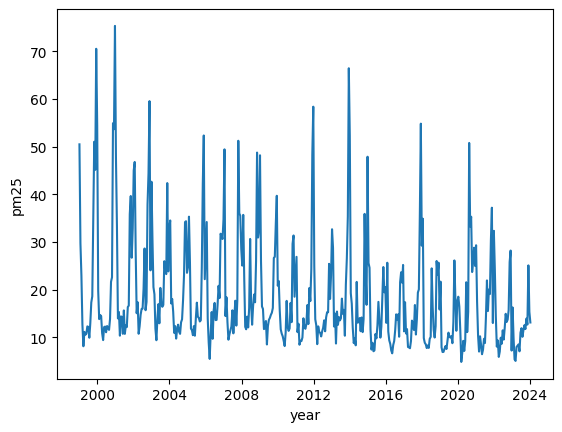

In [5]:
plt.plot(data_mod.index, data_mod['pm25'])
plt.xlabel('year')
plt.ylabel('pm25')

##### Data Temporal Resizing and fill NaN

In [141]:
tem_nan = data_mod['pm25'].isna().any()

if tem_nan:
    print("A coluna 'pm25' contém valores NaN.")
else:
    print("A coluna 'pm25' não contém valores NaN.")

A coluna 'pm25' contém valores NaN.


In [143]:
def resize_data_mod(time_freq):
    global data_mod
    
    reset_data()
    
    data_mod=data_mod.resample(time_freq).mean()
    data_mod_filled = data_mod_resampled.fillna(data_mod_resampled.mean())
resize_data('20D')
data_mod.head(50)

,pm25
day,
1999-01-03,36.879583
1999-01-23,22.308333
1999-02-12,9.915000
1999-03-04,7.916667
1999-03-24,11.505903
1999-04-13,11.309201
1999-05-03,9.500000
1999-05-23,12.177143
1999-06-12,11.807857


##### Data split (train, val,test)

# Analisys

## Convert the date to Unix timestamps ( create new colunnm numerical_date)

In [63]:
def convert_to_numerical_date():
    global data_mod
    data_mod['numerical_date'] = (data_mod.index - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')
    
convert_to_numerical_date()
data_mod.head(1)


,pm25,numerical_date
day,,
1999-01-03,60.0,915321600


## Normalize Data

In [85]:
def normalize_data():
    global data_mod_normalized
    convert_to_numerical_date()
    numeric_columns = ['numerical_date', 'pm25']
    data_mod_numeric = data_mod[numeric_columns]
    data_mod_normalized = (data_mod_numeric - data_mod_numeric.mean()) / data_mod_numeric.std()
    
normalize_data()
data_mod_normalized.head()


,numerical_date,pm25
day,,
1999-01-03,-1.729216,3.318878
1999-01-13,-1.725437,1.419999
1999-01-23,-1.721657,0.680436
1999-02-02,-1.717877,1.016238
1999-02-12,-1.714097,0.481886


## PCA

In [65]:
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(data_mod_normalized)

cumulative_variance_ratio = np.cumsum(pca.explained_variance_ratio_)
plt.plot(cumulative_variance_ratio)
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Proportion of Explained Variance')
plt.title('Cumulative Proportion of Explained Variance by Principal Components')
plt.grid(True)
plt.show()
# Apply PCA
pca = PCA(n_components=2) 

principal_components = pca.fit_transform(data_mod_normalized)

print(pca.explained_variance_ratio_)  # Variance explained by each principal component

component_weights = pca.components_[1]  
temporal_cutoff = component_weights[1] / component_weights[0]  

print("Temporal cutoff interval:", temporal_cutoff)

ValueError: Input X contains NaN.
PCA does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

## MPCA

In [57]:
import tensorly as tl
from tensorly.decomposition import parafac
import numpy as np

numeric_columns = ['numerical_date', 'pm25']
data_mod_numeric = data_mod[numeric_columns]
data_mod_normalized = (data_mod_numeric - data_mod_numeric.mean()) / data_mod_numeric.std()
data_numerical_date = data_mod_normalized['numerical_date'].values.reshape(-1, 1, 1)
data_pm25 = data_mod_normalized['pm25'].values.reshape(-1, 1, 1)



tensor_data = tl.tensor(np.concatenate([data_numerical_date, data_pm25], axis=1))

print("Tensor_data Shape:", tensor_data.shape)

print("Type of tensor_data:", tensor_data.dtype)

# MPCA
components = parafac(tensor_data, rank=2)

# Extract components
component_1 = components.factors[0]  # Componente 1
component_2 = components.factors[1]  # Componente 2


Tensor_data Shape: (916, 2, 1)
Type of tensor_data: float64


LinAlgError: SVD did not converge

In [58]:
print("explained_variance_ratio_ 1:", pca.explained_variance_ratio_[0])
print("explained_variance_ratio_ 2:", pca.explained_variance_ratio_[1])


AttributeError: 'PCA' object has no attribute 'explained_variance_ratio_'

In [25]:
component_1_weights = component_1[:, 0] 
temporal_cutoff = component_1_weights[0] / component_1_weights[1]
print("temporal cut:", temporal_cutoff)

temporal cut: 1.6728946639798707


## MMI (Multivariate Mutual Information)

In [59]:
from sklearn.feature_selection import mutual_info_regression

x = data_mod_normalized[["numerical_date"]]  
y = data_mod_normalized["pm25"]  

mi_score = mutual_info_regression(x, y)[0]

print("Mutual Information between 'numerical_date' and 'pm25':", mi_score)

ValueError: Input y contains NaN.

In [29]:
import numpy as np
from sklearn.feature_selection import mutual_info_regression

time = data_mod_normalized["numerical_date"].values.reshape(-1, 1)
pm25 = data_mod_normalized["pm25"].values

mutual_info = mutual_info_regression(time, pm25)


melhor_corte_temporal = time[np.argmax(mutual_info)]
print(melhor_corte_temporal)
print(mutual_info )


[-1.72638536]
[0.03219085]


## (HE) Holt-Winters Exponential Smoothing

In [44]:
import pandas as pd
from statsmodels.tsa.holtwinters import ExponentialSmoothing

data_he = data_mod[['pm25']].copy()


#data['Date'] = pd.to_datetime(data['Date'])

# data_he['Date'] = pd.to_datetime(data_he['Date'])
# data_he.set_index('Date', inplace=True)
# data_he = data_he.resample(time_freq).mean() 
# start_date = data_he.index[0]
# end_date = data_he.index[-1]
# idx = pd.date_range(start=start_date, end=end_date, freq=time_freq)
# data_he = data_he.reindex(idx)

model = ExponentialSmoothing(data_he['pm25'], seasonal_periods=12, trend=None, seasonal='add')

model_fit = model.fit()

n = 10  
forecast = model_fit.forecast(steps=n)
forecast.head(10)

/home/alex/.local/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


2024-02-01   NaN
2024-02-11   NaN
2024-02-21   NaN
2024-03-02   NaN
2024-03-12   NaN
2024-03-22   NaN
2024-04-01   NaN
2024-04-11   NaN
2024-04-21   NaN
2024-05-01   NaN
Freq: 10D, dtype: float64

In [67]:
forecast.to_csv('data_mod/forecast.csv', index=False)

In [34]:
data_he.tail()

,Daily Mean PM2.5 Concentration
2023-10-24,13.906897
2023-11-13,12.650000
2023-12-03,25.080000
2023-12-23,15.331579
2024-01-12,13.089474


In [135]:
data.tail()

,Date,Source,Site ID,POC,Daily Mean PM2.5 Concentration,UNITS,DAILY_AQI_VALUE,Site Name,DAILY_OBS_COUNT,PERCENT_COMPLETE,AQS_PARAMETER_CODE,AQS_PARAMETER_DESC,CBSA_CODE,CBSA_NAME,STATE_CODE,STATE,COUNTY_CODE,COUNTY,SITE_LATITUDE,SITE_LONGITUDE
23316,2024-01-26,AirNow,60290014,3,8.1,ug/m3 LC,34,Bakersfield-California,1,100.0,88502,Acceptable PM2.5 AQI & Speciation Mass,12540,"Bakersfield, CA",6,California,29,Kern,35.356615,-119.062613
23317,2024-01-27,AirNow,60290014,3,12.0,ug/m3 LC,50,Bakersfield-California,1,100.0,88502,Acceptable PM2.5 AQI & Speciation Mass,12540,"Bakersfield, CA",6,California,29,Kern,35.356615,-119.062613
23318,2024-01-28,AirNow,60290014,3,23.2,ug/m3 LC,74,Bakersfield-California,1,100.0,88502,Acceptable PM2.5 AQI & Speciation Mass,12540,"Bakersfield, CA",6,California,29,Kern,35.356615,-119.062613
23319,2024-01-29,AirNow,60290014,3,25.6,ug/m3 LC,79,Bakersfield-California,1,100.0,88502,Acceptable PM2.5 AQI & Speciation Mass,12540,"Bakersfield, CA",6,California,29,Kern,35.356615,-119.062613
23320,2024-01-30,AirNow,60290014,3,12.8,ug/m3 LC,52,Bakersfield-California,1,100.0,88502,Acceptable PM2.5 AQI & Speciation Mass,12540,"Bakersfield, CA",6,California,29,Kern,35.356615,-119.062613
